In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [53]:
# prep data, create vocab
df = pd.read_csv(r"C:\space\elton\UT\TextAnalysis\transcript_embeddings\data\exp_12_15_351_utterances_processed.csv",
                 usecols=["utterance"])

df["utterance"] = df["utterance"].str.lower()
df_tokens = " ".join(df["utterance"]).split()
unique_tokens = list(set(df_tokens))


In [54]:
# make vocabulary
indexes = [i for i in range(0, len(unique_tokens))]

vocab = dict(zip(unique_tokens, indexes))
reverse_vocab = dict(zip(indexes, unique_tokens))

In [55]:
# turn tokens into list
sentence1 = df.loc[0 , "utterance"]

list_sentence = [vocab[word] for word in sentence1.lower().split()]

print(sentence1)
print(list_sentence)
print([reverse_vocab[index] for index in list_sentence])

what did you find
[323, 1415, 888, 97]
['what', 'did', 'you', 'find']


In [56]:
# this works to get context and is kinda cool but idk looks clearner and smatter way of doing it 
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = window_size
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [57]:
def get_pos_context(tokens, window):
    # we have to know the position of the token in the array
    # so that we can comfirm that there are enough tokens to use 
    # that window size 
    context = []
    
    for i, token in enumerate(tokens):
        context.append([token, get_target(tokens, i, 1)])

        """
        if i == 0:
            pos_context = [tokens[i+window]]
        elif i == len(tokens) -1:
            pos_context = [tokens[i-window]]
        else:
            pos_context = [tokens[i-window], tokens[i+window]]
        """
        
        #context.append([token, pos_context])
    return context

In [58]:
get_pos_context(list_sentence, 1)

[[323, [1415]], [1415, [323, 888]], [888, [1415, 97]], [97, [888]]]

In [59]:
# check that it works lol 
val = get_pos_context(list_sentence, 1)

def show_context(val):

    x = []
    y = []

    for target in val:
        y = []
        for context in target[1]:
            y.append(reverse_vocab[context])
        x.append([reverse_vocab[target[0]], y])
    print(x)

print(sentence1)
show_context(val)

what did you find
[['what', ['did']], ['did', ['what', 'you']], ['you', ['did', 'find']], ['find', ['you']]]


In [60]:
# get negative examples 
def get_neg_context(pos_context, num):
    neg_context = []
    
    for token in pos_context:
        neg_instances = []
        for context in token[1]:
            samples = []
            for i in range(0, num):
                neg = np.random.randint(1, len(vocab)+1)

                if neg not in token[1]:
                    samples.append(neg)
            neg_instances.append(samples)
        neg_context.append([token[0], neg_instances])
    return neg_context

In [88]:
# each context instance is a training instance so 
# the negative sampling should match that ratio 
context = get_pos_context(list_sentence, 1)
neg_context = get_neg_context(context, 2)

print(context)
neg_context

[[323, [1415]], [1415, [323, 888]], [888, [1415, 97]], [97, [888]]]


[[323, [[1399, 1542]]],
 [1415, [[1134, 1647], [971, 990]]],
 [888, [[1014, 157], [533, 253]]],
 [97, [[1692, 1300]]]]

In [89]:
# concatenate positive and negative skipgrams
# create its y-labels
ngrams, contexts, labels = [], [], []

def process_skipgrams(sentence, window, num=0):
        # change tokenizer 
        tokens = [vocab[word] for word in sentence.lower().split()]

        pos_context = get_pos_context(tokens, window)
        #[ngrams.append(i) for i in pos_context]
        #neg_context = get_neg_context(pos_context, num)

        for i, token in enumerate(pos_context):
               for j, context in enumerate(token[1]):
                        instance_context = [pos_context[i][1][j]] #+ neg_context[i][1][j]
        #                label = [1] + [0 for i in range(num)]
                        ngrams.append(token[0])
                        contexts.append(instance_context)
        #                labels.append(label)


In [90]:
df["utterance"].apply(lambda x: process_skipgrams(x, 1, 1))

0       None
1       None
2       None
3       None
4       None
        ... 
5139    None
5140    None
5141    None
5142    None
5143    None
Name: utterance, Length: 5144, dtype: object

In [92]:
print(len(ngrams), len(contexts), len(labels))
print(f"\nTarget:{ngrams[:10]}\nContexts:{contexts[:10]}\nLabels{labels[:10]}")

106842 106842 0

Target:[323, 1415, 1415, 888, 888, 97, 1256, 815, 815, 597]
Contexts:[[1415], [323], [888], [1415], [97], [888], [815], [1256], [597], [815]]
Labels[]


### Define Model

In [93]:
EMBEDDING_DIM = 10
CONTEXT_SIZE = 1 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def train(epoch, name):
    for i in range(epoch):
        total_loss = 0
        for instance, target in enumerate(ngrams):
            context = contexts[instance]

            # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
            # into integer indices and wrap them in tensors)
            context_idxs = torch.tensor(context, dtype=torch.long)
            target = torch.tensor([target], dtype=torch.long)

            # send to device
            context_idxs = context_idxs.to(device)
            target = target.to(device)

            # Step 2. Recall that torch *accumulates* gradients. Before passing in a
            # new instance, you need to zero out the gradients from the old
            # instance
            model.zero_grad()

            # Step 3. Run the forward pass, getting log probabilities over next
            # words

            log_probs = model(context_idxs)

            # Step 4. Compute your loss function. (Again, Torch wants the target
            # word wrapped in a tensor

            loss = loss_function(log_probs, target)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()
        losses.append(total_loss)
    print(losses)  # The loss decreased every iteration over the training data!

    # To get the embedding of a particular word, e.g. "beauty"
    #print(model.embeddings.weight[vocab["appeal"]])
    torch.save(model, name + ".pt")



### Sannity Check

In [157]:
with open("training_text.txt", "r") as file:
    data = file.read()
data = data.split(".")
data = [x.replace(",","").strip() for x in data]
data_list = [sentence.split() for sentence in data]

In [158]:
unique_tokens = set([word.lower() for sentence in data_list for word in sentence])

indexes = [i for i in range(0, len(unique_tokens))]

vocab = dict(zip(unique_tokens, indexes))
reverse_vocab = dict(zip(indexes, unique_tokens))


In [159]:
ngrams, contexts, labels = [], [], []

[process_skipgrams(sentence, 1) for sentence in data]
print(len(ngrams), len(contexts), len(labels))
print(f"\nTarget:{ngrams[:10]}\nContexts:{contexts[:10]}\nLabels{labels[:10]}")

228 228 0

Target:[30, 54, 54, 37, 37, 16, 16, 15, 15, 18]
Contexts:[[54], [30], [37], [54], [16], [37], [15], [16], [18], [15]]
Labels[]


In [162]:
train(30, "sanity_check")

[4959085.44082278, 4726886.398088902, 4670662.208977789, 4632244.806633115, 4602539.85949713, 4578067.010765582, 4557114.6248961985, 4538641.996898264, 4521948.559521794, 4506699.214590758, 0, 0, 2608.607633113861, 2324.0921874046326, 2075.339277625084, 1878.1830248236656, 1738.7614849805832, 1632.9436318278313, 1550.3426654338837, 1480.3329263925552, 1419.0230380296707, 1365.2425910830498, 1316.889916241169, 1271.6294116973877, 1228.3148918151855, 1186.7085087895393, 1146.8725850582123, 1108.8494052886963, 1072.5906730294228, 1038.003607392311, 1005.0180712342262, 973.6083593964577, 943.7723426222801, 915.5055095553398, 888.7874814271927, 863.5659504532814, 839.7456265687943, 817.207755625248, 795.8377023339272, 775.5242677330971, 756.1691707968712, 737.6956212520599, 720.0488886833191, 703.1794994473457, 687.0472012162209, 671.6130813360214, 656.8503565192223, 642.7291369438171, 629.2321740984917, 616.3464308977127, 604.0588166713715, 592.3577210307121, 581.231736779213, 570.67665231

In [94]:
model_ft = torch.load(r"C:\space\elton\UT\TextAnalysis\transcript_embeddings\models\4_2-10epoch.pt")
print(model_ft.embeddings.weight[vocab["toy"]])

tensor([-1.9083,  0.3978, -1.1476,  1.1213,  1.6255, -1.5320, -0.4631, -0.4677,
        -1.0071,  1.7121], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
embeddings.s

In [105]:
from sklearn.decomposition import PCA

embeddings = model_ft.embeddings.weight.to('cpu').data.numpy()
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

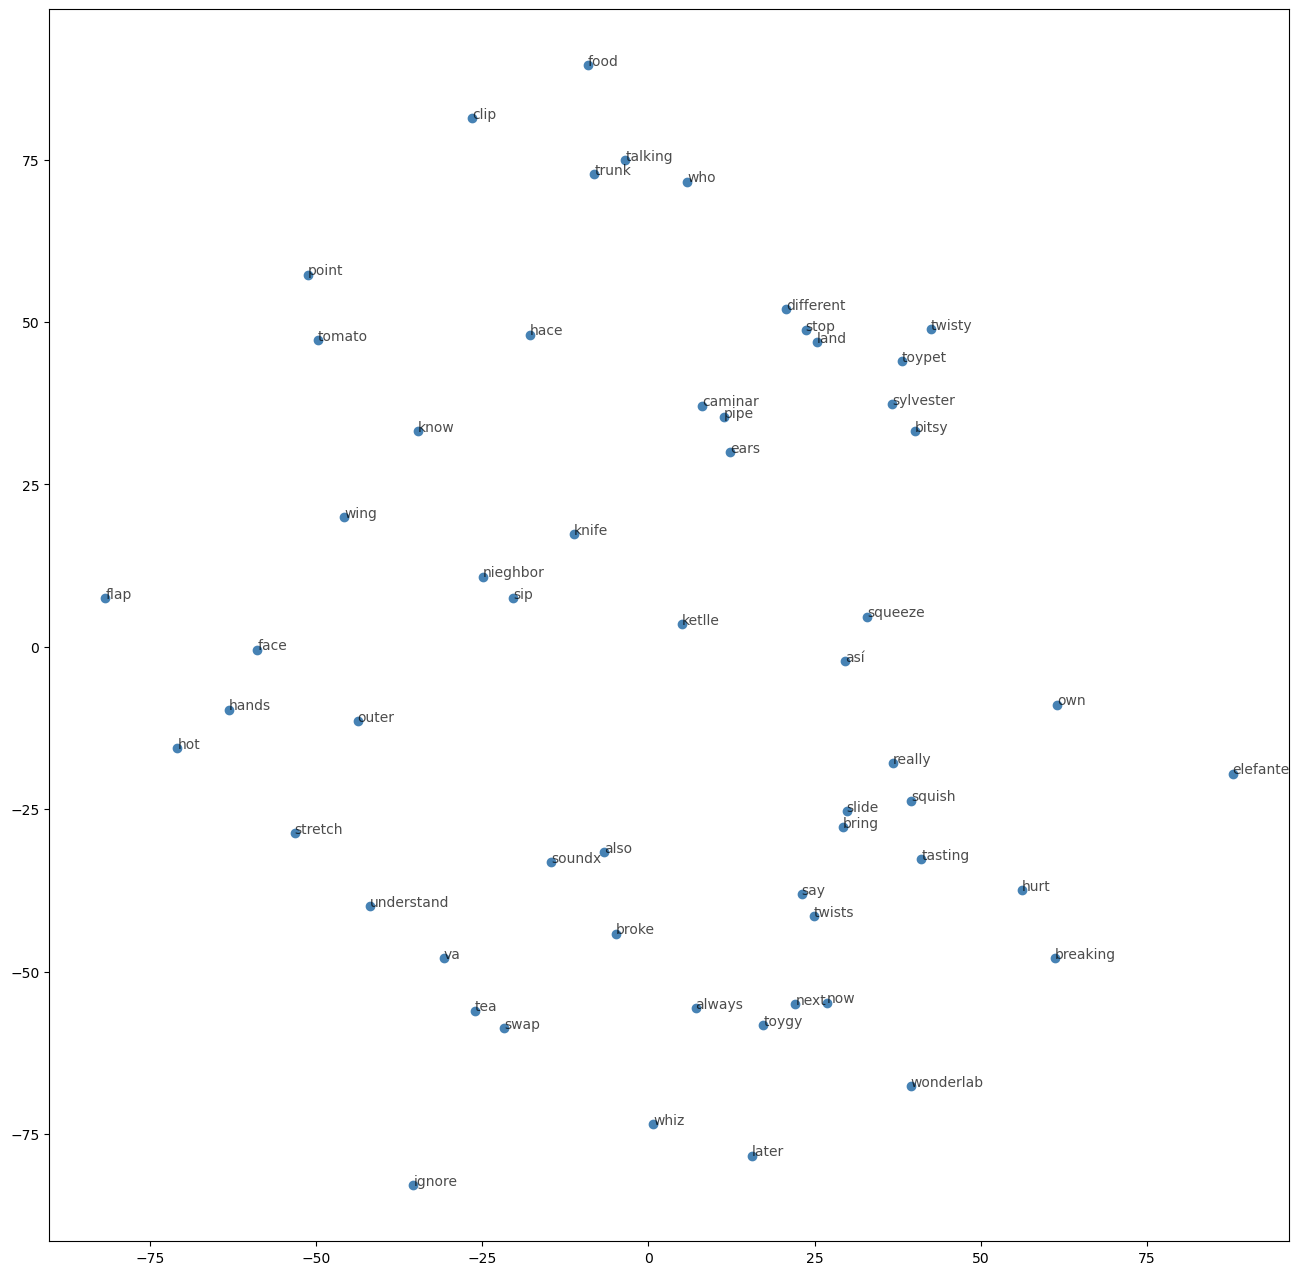

In [97]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeddings = model_ft.embeddings.weight.to('cpu').data.numpy()

viz_words = 58
tsne = TSNE()


shuffled = np.copy(embeddings)
np.random.shuffle(shuffled)

embed_tsne = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(reverse_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
